In [1]:
import pandas as pd
import numpy as np
import re
import time
import string
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
import sklearn 
from sklearn import *
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

### Load Data

In [2]:
df = pd.read_csv('final_metadata.csv')

### Split training and testing data

In [3]:
X = pd.DataFrame()
for i in ['runtime', 'budget', 'revenue', 'popularity', 'year', 
         'Action', 'Adventure', 'Animation', 'Aniplex', 'BROSTA TV',
       'Carousel Productions', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Foreign', 'GoHands', 'History', 'Horror',
       'Mardock Scramble Production Committee', 'Music', 'Mystery',
       'Odyssey Media', 'Pulser Productions', 'Rogue State', 'Romance',
       'Science Fiction', 'Sentai Filmworks', 'TV Movie',
       'Telescene Film Group Productions', 'The Cartel', 'Thriller',
       'Vision View Entertainment', 'War', 'Western']:
    X[i] = df[i]
Y = pd.DataFrame(df['Y'])
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8)
print ('Shape of the X_train:', X_train.shape)
print ('Shape of the Y_test:', y_test.shape)

Shape of the X_train: (36276, 37)
Shape of the Y_test: (9070, 1)


### Feature transform

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
S = StandardScaler()
X_train = S.fit_transform(X_train)
X_test = S.fit_transform(X_test)

# Logistic Regression

In [6]:
lr = sklearn.linear_model.LogisticRegression(C = 1e30)
lr.fit(X_train, y_train)
y_prob = lr.predict_proba(X_test)[:,1]
y_pred = lr.predict(X_test)

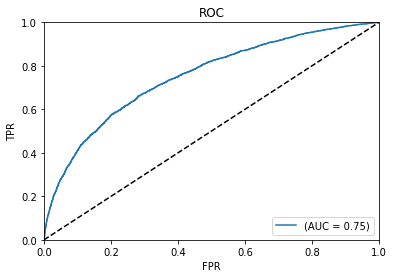

In [7]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr,label = '(AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")

In [8]:
auc = roc_auc_score(y_test,y_prob)
auc

0.7515919899595729

### Pyspark on Logistics Regression


In [9]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from operator import add # Required for reduceByKey
import re
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from numpy import array
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from time import time
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import time

start_time = time.time()
sc = SparkContext(master="local", appName="lg")
#create RDD
text = sc.textFile('final_metadata.csv')

#remove header
header = text.first() #extract header
header1 = sc.parallelize([header])
text = text.subtract(header1)  #filter out header

#split train and test
train, test = text.randomSplit([0.8, 0.2])

#mapping function
def parse_interaction(line):
    row = line.split(",")
    final_row = row[1:-2]
    ll = row[-1]
    return LabeledPoint(ll, array([float(i) for i in final_row]))

#map
train = train.map(parse_interaction)
test = test.map(parse_interaction)

#logistics regression trainning
lm = LogisticRegressionWithLBFGS.train(train)

pred_auc = test.map(lambda y: (float(y.label), float(lm.predict(y.features))))
metrics = BinaryClassificationMetrics(pred_auc)
print('The auc is %s:'% metrics.areaUnderROC)

#run time
end_time = time.time()
print("run_time: %f s" % (end_time - start_time))

The auc is 0.7109342612368751:
run_time: 24.830640 s
